# Cone detection
**Author:** <a class="mailto" href="mailto:yangchenhao@campus.technion.ac.il">Chenhao Yang</a>

**Description:** We created 3D point cloud data to simulate LiDAR scannings for supervised training. Our detection approach is to voxelize the point cloud and create pseudo images first, and then using 2D convolution layers and variational autoencoder model for feature extraction and generation of cone coordinate candidates. Finally, we used non-maximum suppression to get outputs and fine results.


In [ ]:
# import necessary libraries
# make sure you are assigned with a GPU, otherwise it would take too much time to train with CPU.

import os
import sys
import cv2
import csv
import glob
import math
import torch
import matplotlib
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

torch.manual_seed(1)
torch.device('cuda')

device(type='cuda')

In [ ]:
# this library colab didn't install by default
!pip install plyfile
from plyfile import PlyData

### Upload training data 'mydataset.zip' from my own drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp -R /content/gdrive/My\ Drive/formula/myDataset.zip /content
# !cp -R /content/gdrive/My\ Drive/formula/test_data.npy /content
# !cp -R /content/gdrive/My\ Drive/formula/train_data.npy /content
# !cp -R /content/gdrive/My\ Drive/formula/test_positions.npy /content
# !cp -R /content/gdrive/My\ Drive/formula/train_positions.npy /content

In [ ]:
!cd /content
!unzip myDataset.zip

## Pre-processing

In [ ]:
def raw_to_voxel(pc, resolution=0.1, x=(0, 90), y=(-50, 50), z=(-4.5, 5.5)):
    """Convert PointCloud to Voxel"""
    logic_x = np.logical_and(pc[:, 0] >= x[0], pc[:, 0] < x[1])
    logic_y = np.logical_and(pc[:, 1] >= y[0], pc[:, 1] < y[1])
    logic_z = np.logical_and(pc[:, 2] >= z[0], pc[:, 2] < z[1])
    pc = pc[:, :3][np.logical_and(logic_x, np.logical_and(logic_y, logic_z))]
    
    pc =((pc - np.array([x[0], y[0], z[0]])) / resolution).astype(np.int32)
    voxel = np.zeros((int((x[1] - x[0]) / resolution), int((y[1] - y[0]) / resolution), int(round((z[1]-z[0]) / resolution))))
    for i in range(pc.shape[0]):
      voxel[pc[i, 0], pc[i, 1], pc[i, 2]] = 1
    # # voxel[pc[:,0], pc[:, 1], pc[:, 2]] = 1
    
    return voxel, pc

In [ ]:
def data_loader(folder):
  voxels = []
  n = 100
  positions=np.empty((2048,3,n)) # always filled
  # positions=np.empty((2048,2,10)) # not always filled

  files = sorted(glob.glob(os.path.join(folder, 'ply/*')))
  pos_files = sorted(glob.glob(os.path.join(folder, 'csv/*')))

  for f in files:
    plydata = PlyData.read(f)
    x = np.array(plydata.elements[0].data['x'])
    y = np.array(plydata.elements[0].data['y'])
    z = np.array(plydata.elements[0].data['z'])
    x = np.expand_dims(x,1)
    y = np.expand_dims(y,1)
    z = np.expand_dims(z,1)
    xy = np.hstack((x, y))
    pc = np.hstack((xy, z))
    
    # ---------------------------add noise-----------------------------#
    mu, sigma = 0.0, 0.0 # mean and standard deviation
    s = np.random.normal(mu, sigma, pc.shape)
    pc = pc + s

    voxel, npc = raw_to_voxel(pc, resolution=0.1, x=(-5, 5), y=(0, 5), z=(0, 0.3))
    voxels.append(voxel)
  
  j=0
  for f in pos_files:
    with open(f, 'r') as file:
      reader = csv.reader(file)
      i=0
      for row in reader:
        row = np.array(row)
        num_loops = math.floor(n/len(row))
        remainder = n%len(row)
        for k in range(num_loops):
          positions[j][i][len(row)*k:len(row)*(k+1)] = row
        positions[j][i][n-remainder:] = row[0:remainder]
        i=i+1
    j=j+1
  positions[:,2,:] = 0.2

  # j=0
  # for f in pos_files:
  #   with open(f, 'r') as file:
  #     reader = csv.reader(file)
  #     i=0
  #     for row in reader:
  #       positions[j][i][0:len(row)] = np.array(row) 
  #       i=i+1
  #   j=j+1

  voxels = np.array(voxels)
  total = len(files)
  train_voxels, test_voxels= voxels[0:int(0.8*total)], voxels[int(0.8*total)+1:]
  train_positions, test_positions= positions[0:int(0.8*total)], positions[int(0.8*total)+1:]
  return train_voxels, test_voxels, train_positions, test_positions, pc

In [ ]:
def Voxel2PseudoImage(voxel):
  """convert voxel to pesudo BEV image"""
  Image = np.zeros(voxel.shape[0:2])
  for i in range(voxel.shape[2]):
    Image = np.add(Image, 10*(i+1)*voxel[:,:,i])

  return Image/(np.max(Image)-np.min(Image))

### Call functions to generate training/testing data

Takes about 1 minute

In [ ]:
DATA_DIR = '/content/myDataset'
train_voxels, test_voxels, train_positions, test_positions, pc= data_loader(DATA_DIR)

train_data = np.empty(train_voxels.shape[0:3]) # [m,x,y]
test_data = np.empty(test_voxels.shape[0:3]) # [n,x,y]

# turn voxels to pseudo images

for i in range(train_data.shape[0]):
  train_data[i,:,:]=Voxel2PseudoImage(train_voxels[i])

for i in range(test_data.shape[0]):
  test_data[i,:,:]=Voxel2PseudoImage(test_voxels[i])

### Optional: save variables and reload

In [ ]:
np.save('train_data',train_data)
np.save('train_positions',train_positions)
np.save('test_data',test_data)
np.save('test_positions',test_positions)

In [ ]:
train_data = np.load('train_data.npy')
train_positions = np.load('train_positions.npy')
test_data = np.load('test_data.npy')
test_positions = np.load('test_positions.npy')
print(train_data.shape)
print(train_positions.shape)

(1638, 100, 50)
(1638, 3, 100)


## Visualize Voxels and BEV Pseudo Images

In [ ]:
pc.shape

(3218, 3)

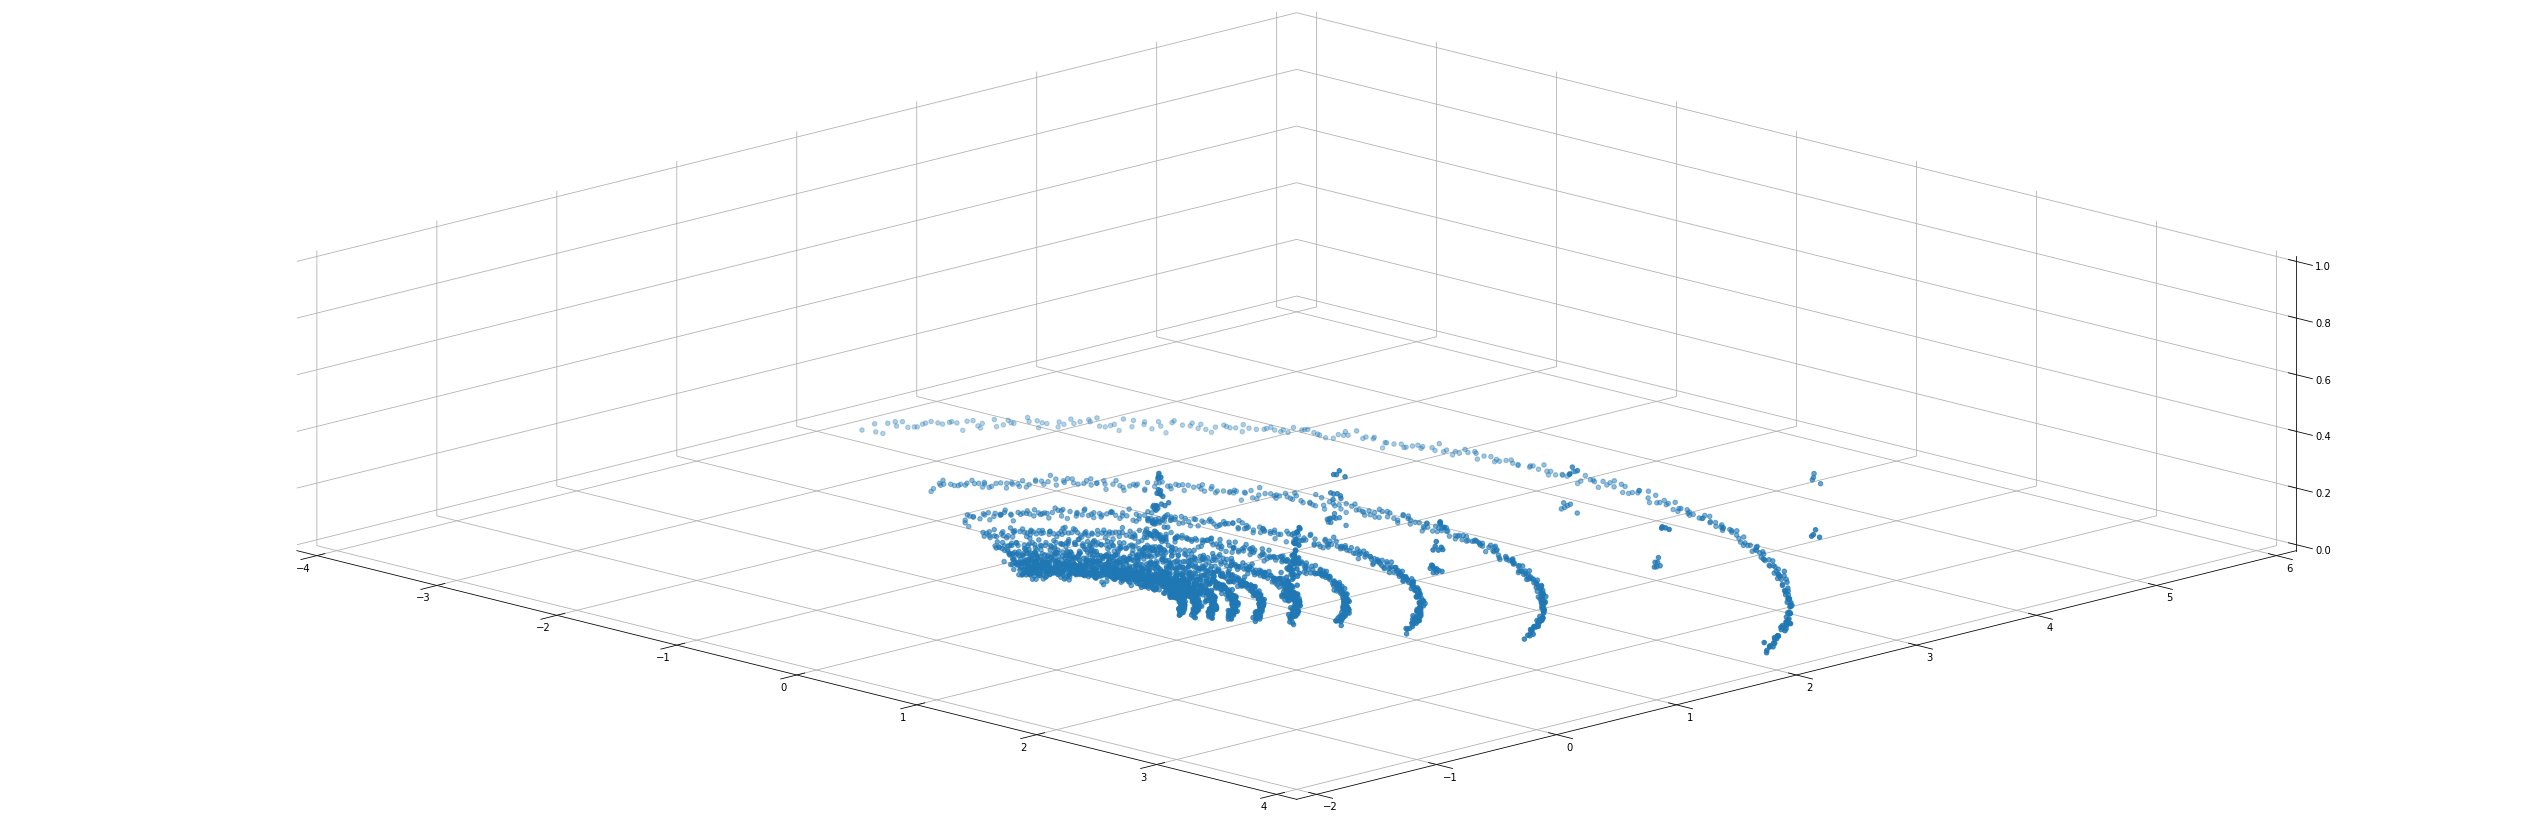

In [ ]:
# and plot everything
ax = plt.figure(figsize=(45,15)).add_subplot(projection='3d')
x=pc[:,0]
y = pc[:,1]
z = pc[:,2]
h = ax.scatter3D(x, y, z);
ax.set_xlim(-4, 4)
ax.set_ylim(-2, 6)
ax.set_zlim(0, 1)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Bonus: To get rid of the grid as well:
# ax.grid(False)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)

ax.set_proj_type('ortho')
ax.view_init(50, 270+45)
plt.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


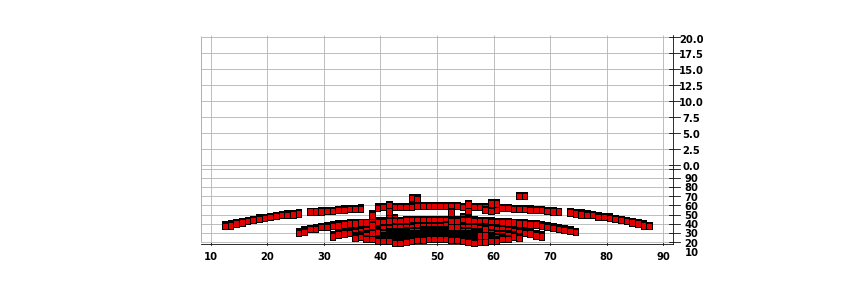

In [ ]:
voxels = train_voxels[1]

# and plot everything
ax = plt.figure(figsize=(15,5)).add_subplot(projection='3d')
ax.voxels(voxels, facecolors='r', edgecolor='k')
ax.set_xlim(10, 90)
ax.set_ylim(10, 90)
ax.set_zlim(0, 20)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])
# Get rid of colored axes planes
# First remove fill
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Bonus: To get rid of the grid as well:
# ax.grid(False)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)
ax.set_proj_type('ortho')
ax.view_init(30, 270)
plt.show()

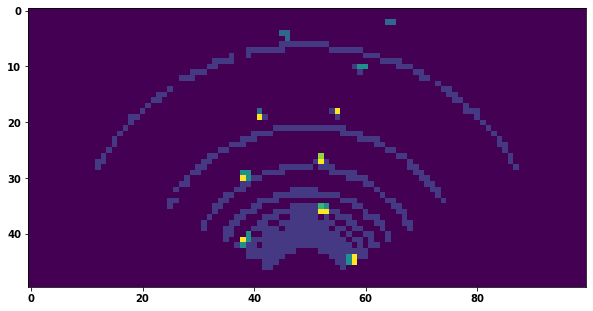

In [ ]:
Img = train_data[1]
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)
Img = np. rot90(Img)
plt.figure(figsize=(10,8))
plt.imshow(Img)
plt.show()

## Deep learning stuff...

In [ ]:
# Hyperparameters
num_epochs = 400
batch_size = 32
learning_rate = 0.001

In [ ]:
# A function to count the number of parameters in an nn.Module.
def num_params(layer):
    return sum([p.numel() for p in layer.parameters()])

In [ ]:
x0 = train_data[0]
x0 = np.expand_dims(x0,0)
# x0 = np.expand_dims(x0,0) # [batch_size, input_channel, x, y]

print(f'{"Input image shape:":25s}{x0.shape}')
# x0 = np.random.random((3,32,32))
x0 = torch.from_numpy(x0).float()
# add batch dimension
x0 = x0.unsqueeze(0)

# First conv layer: works on input image volume
conv1 = nn.Conv2d(in_channels=1, out_channels=10, padding=1, kernel_size=3, stride=2)
print(f'conv1: {num_params(conv1)} parameters')
y1 = conv1(x0)
print(f'{"After first conv layer:":25s}{y1.shape}')

Input image shape:       (1, 100, 50)
conv1: 100 parameters
After first conv layer:  torch.Size([1, 10, 50, 25])


### Training model

In [ ]:
class VAENet(nn.Module):
    def __init__(self):
        super(VAENet, self).__init__()

        # encoder
        channels = [16, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, channels[0], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(channels[0], channels[1], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2))
        
        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=channels[1],
                               out_channels=channels[0],
                               kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(channels[0]),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=channels[0],
                               out_channels=8,
                               kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(8)
        )
        self.regression = nn.Sequential(
            # nn.Linear(9600, 200, bias=True)
            nn.Linear(37224, 200, bias=True)
        )
        

    def forward(self, x):
      out = self.encoder(x)
      out = self.decoder(out)
      out = out.reshape(out.size(0), -1)
      out = self.regression(out)
      return out

In [ ]:
model = VAENet()
model = model.to(device='cuda')

# Loss and optimizer
criterion = nn.MSELoss() # L2 loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

VAENet(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (regression): Sequential(
    (0): Linear(in_features=37224, out_features=200, bias=True)
  )
)


In [ ]:
x0 = torch.rand((32,1,100,50),device='cuda')
y0 = model(x0)
print(f'{"After layers:":25s}{y0.shape}')

After layers:            torch.Size([32, 200])


Notes: 

I did not use a commonly used dataloader (I should do so) and manually defined each batch, etc. It won't affect the final results, just not neat.

In [ ]:
# Train the model
total_step = math.floor(len(train_data)/batch_size)
loss_list = []
model.train()
for epoch in range(num_epochs):
    for i in range(total_step):
        images = train_data[batch_size*i:batch_size*(i+1),:,:].copy()
        labels = train_positions[batch_size*i:batch_size*(i+1),:,:].copy()
        # without r
        labels = labels[:,0:2,:]
        # normalize
        labels[:,0,:] = (labels[:,0,:] + 5)/10*100 #x
        labels[:,1,:] = (labels[:,1,:])/5*100    #y
        labels = labels.reshape(batch_size, 200)
        
        images = np.expand_dims(images,1)
        images = torch.from_numpy(images).float().to(device='cuda')
        labels = torch.from_numpy(labels).float().to(device='cuda')
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
              .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


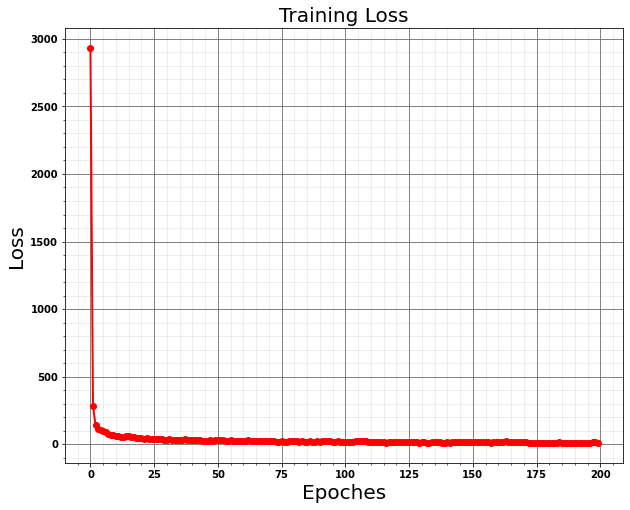

In [ ]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']

loss_rec = np.asarray(loss_list)
epochs = np.arange(0,400,1)
loss_idxs = np.arange(0, 400*51, 51)
losses = loss_rec[loss_idxs]

fig = plt.figure(figsize=(10,8))

plt.plot(epochs, losses, 'ro-', linewidth=2)
plt.title('Training Loss',fontsize=20)
plt.xlabel('Epoches',fontsize=20)
plt.ylabel('Loss',fontsize=20)
# Show the major grid lines with dark grey lines
plt.grid(b=True, which='major', color='#666666', linestyle='-')

# Show the minor grid lines with very faint and almost transparent grey lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

# leg = plt.legend(['Eigenvalues from SVD'], loc='best')
plt.show()

In [ ]:
loss_rec = np.asarray(loss_list)
print(np.mean(loss_rec[50*51:]))

17.936759676029478


### TEST

In [ ]:
total_step = math.floor(len(test_data)/batch_size)
loss_test=[]
for i in range(total_step):
    images = test_data[batch_size*i:batch_size*(i+1),:,:].copy()
    labels = test_positions[batch_size*i:batch_size*(i+1),:,:].copy()
    # without r
    labels = labels[:,0:2,:]
    # normalize
    labels[:,0,:] = (labels[:,0,:] + 5)/10*100 #x
    labels[:,1,:] = (labels[:,1,:])/5*100    #y
    labels = labels.reshape(batch_size, 200)

    images = np.expand_dims(images,1)
    images = torch.from_numpy(images).float().to(device='cuda')
    labels = torch.from_numpy(labels).float().to(device='cuda')
    
    # evaluate model:
    model.eval()

    with torch.no_grad():
      outputs = model(images)
    
    loss = criterion(outputs, labels)
    loss_test.append(loss.item())
loss_mean = np.mean(loss_test)    
print('Test loss of model is {}'.format(loss_mean))
model.train()

In [ ]:
def get_boxcorners(places, size):
    """Create 8 corners of bounding box from bottom center."""
    corners = []
    for place, sz in zip(places, size):
        x, y, z = place
        h, w, l = sz

        corner = np.array([
            [x - l / 2., y - w / 2., z],
            [x + l / 2., y - w / 2., z],
            [x + l / 2., y + w / 2., z],
            [x - l / 2., y + w / 2., z],
            [x - l / 2., y - w / 2., z + h],
            [x + l / 2., y - w / 2., z + h],
            [x + l / 2., y + w / 2., z + h],
            [x - l / 2., y + w / 2., z + h],
        ])

        # corner += np.array([x, y, z])
        corners.append(corner)
    return np.array(corners)

In [ ]:
def illustration(DATA_DIR, id_pointcloud, output, state):
  # id_pointcloud a number
  f = os.path.join(DATA_DIR, 'ply',format(id_pointcloud, '04d')+'.ply')
  GT = os.path.join(DATA_DIR, 'csv',format(id_pointcloud, '04d')+'.csv')
  plydata = PlyData.read(f)
  x = np.array(plydata.elements[0].data['x'])
  y = np.array(plydata.elements[0].data['y'])
  z = np.array(plydata.elements[0].data['z'])

  # and plot everything
  ax = plt.figure(figsize=(45,15)).add_subplot(projection='3d')
  h = ax.scatter3D(x, y, z);
  ax.set_xlim(-4, 4)
  ax.set_ylim(-2, 6)
  ax.set_zlim(0, 1)
  # ax.set_xticks([])
  # ax.set_yticks([])
  # ax.set_zticks([])
  # Get rid of colored axes planes
  # First remove fill
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

  # Now set color to white (or whatever is "invisible")
  ax.xaxis.pane.set_edgecolor('w')
  ax.yaxis.pane.set_edgecolor('w')
  ax.zaxis.pane.set_edgecolor('w')

  # Bonus: To get rid of the grid as well:
  # ax.grid(False)

  ax.set_proj_type('ortho')
  ax.view_init(50, 270+45)

  # Ground truth!!!
  df = pd.read_table(GT,sep=',',header=None)
  places_xy = df.values
  places_z = np.zeros((1, places_xy.shape[1]))
  places = np.vstack((places_xy, places_z)).T
  w = np.ones((1, places_xy.shape[1]))*0.2
  l = np.ones((1, places_xy.shape[1]))*0.2
  h = np.ones((1, places_xy.shape[1]))*0.3
  size = np.vstack((w,l))
  size = np.vstack((size,h)).T
  corners = get_boxcorners(places, size)
  x_cos = corners[:,:,0]
  y_cos = corners[:,:,1]
  z_cos = corners[:,:,2]

  linewid = 2
  for i in range(corners.shape[0]):
    x_co = x_cos[i,:]
    y_co = y_cos[i,:]
    z_co = z_cos[i,:]

    ax.plot3D(x_co[0:4],y_co[0:4],z_co[0:4], 'green',linewidth=linewid)
    ax.plot3D(x_co[4:8],y_co[4:8],z_co[4:8], 'green',linewidth=linewid)
    ax.plot3D([x_co[0], x_co[3]], [y_co[0], y_co[3]],[z_co[0], z_co[3]] ,'green',linewidth=linewid)
    ax.plot3D([x_co[4], x_co[7]], [y_co[4], y_co[7]],[z_co[4], z_co[7]] ,'green',linewidth=linewid)

    ax.plot3D([x_co[0], x_co[4]], [y_co[0], y_co[4]],[z_co[0], z_co[4]] ,'green',linewidth=linewid)
    ax.plot3D([x_co[1], x_co[5]], [y_co[1], y_co[5]],[z_co[1], z_co[5]] ,'green',linewidth=linewid)
    ax.plot3D([x_co[2], x_co[6]], [y_co[2], y_co[6]],[z_co[2], z_co[6]] ,'green',linewidth=linewid)
    ax.plot3D([x_co[3], x_co[7]], [y_co[3], y_co[7]],[z_co[3], z_co[7]] ,'green',linewidth=linewid)

  # results
  if state == 0:
    output_xyh = output.reshape(2,100)
  if state == 1:
    output_xyh = output
  z = np.zeros((1, output_xyh.shape[1]))
  places = np.vstack((output_xyh[0:2,:], z)).T
  w = np.ones((1, z.shape[1]))*0.2
  l = np.ones((1, z.shape[1]))*0.2
  h = np.ones((1, z.shape[1]))*0.3
  size = np.vstack((w,l))
  size = np.vstack((size,h)).T
  corners = get_boxcorners(places, size)
  x_cos = corners[:,:,0]
  y_cos = corners[:,:,1]
  z_cos = corners[:,:,2]

  for i in range(corners.shape[0]):
    x_co = x_cos[i,:]
    y_co = y_cos[i,:]
    z_co = z_cos[i,:]

    ax.plot3D(x_co[0:4],y_co[0:4],z_co[0:4], 'red')
    ax.plot3D(x_co[4:8],y_co[4:8],z_co[4:8], 'red')
    ax.plot3D([x_co[0], x_co[3]], [y_co[0], y_co[3]],[z_co[0], z_co[3]] ,'red')
    ax.plot3D([x_co[4], x_co[7]], [y_co[4], y_co[7]],[z_co[4], z_co[7]] ,'red')

    ax.plot3D([x_co[0], x_co[4]], [y_co[0], y_co[4]],[z_co[0], z_co[4]] ,'red')
    ax.plot3D([x_co[1], x_co[5]], [y_co[1], y_co[5]],[z_co[1], z_co[5]] ,'red')
    ax.plot3D([x_co[2], x_co[6]], [y_co[2], y_co[6]],[z_co[2], z_co[6]] ,'red')
    ax.plot3D([x_co[3], x_co[7]], [y_co[3], y_co[7]],[z_co[3], z_co[7]] ,'red')


  font = {'family' : 'normal',
          'weight' : 'bold',
          'size'   : 30}

  matplotlib.rc('font', **font)
  plt.show()
  return


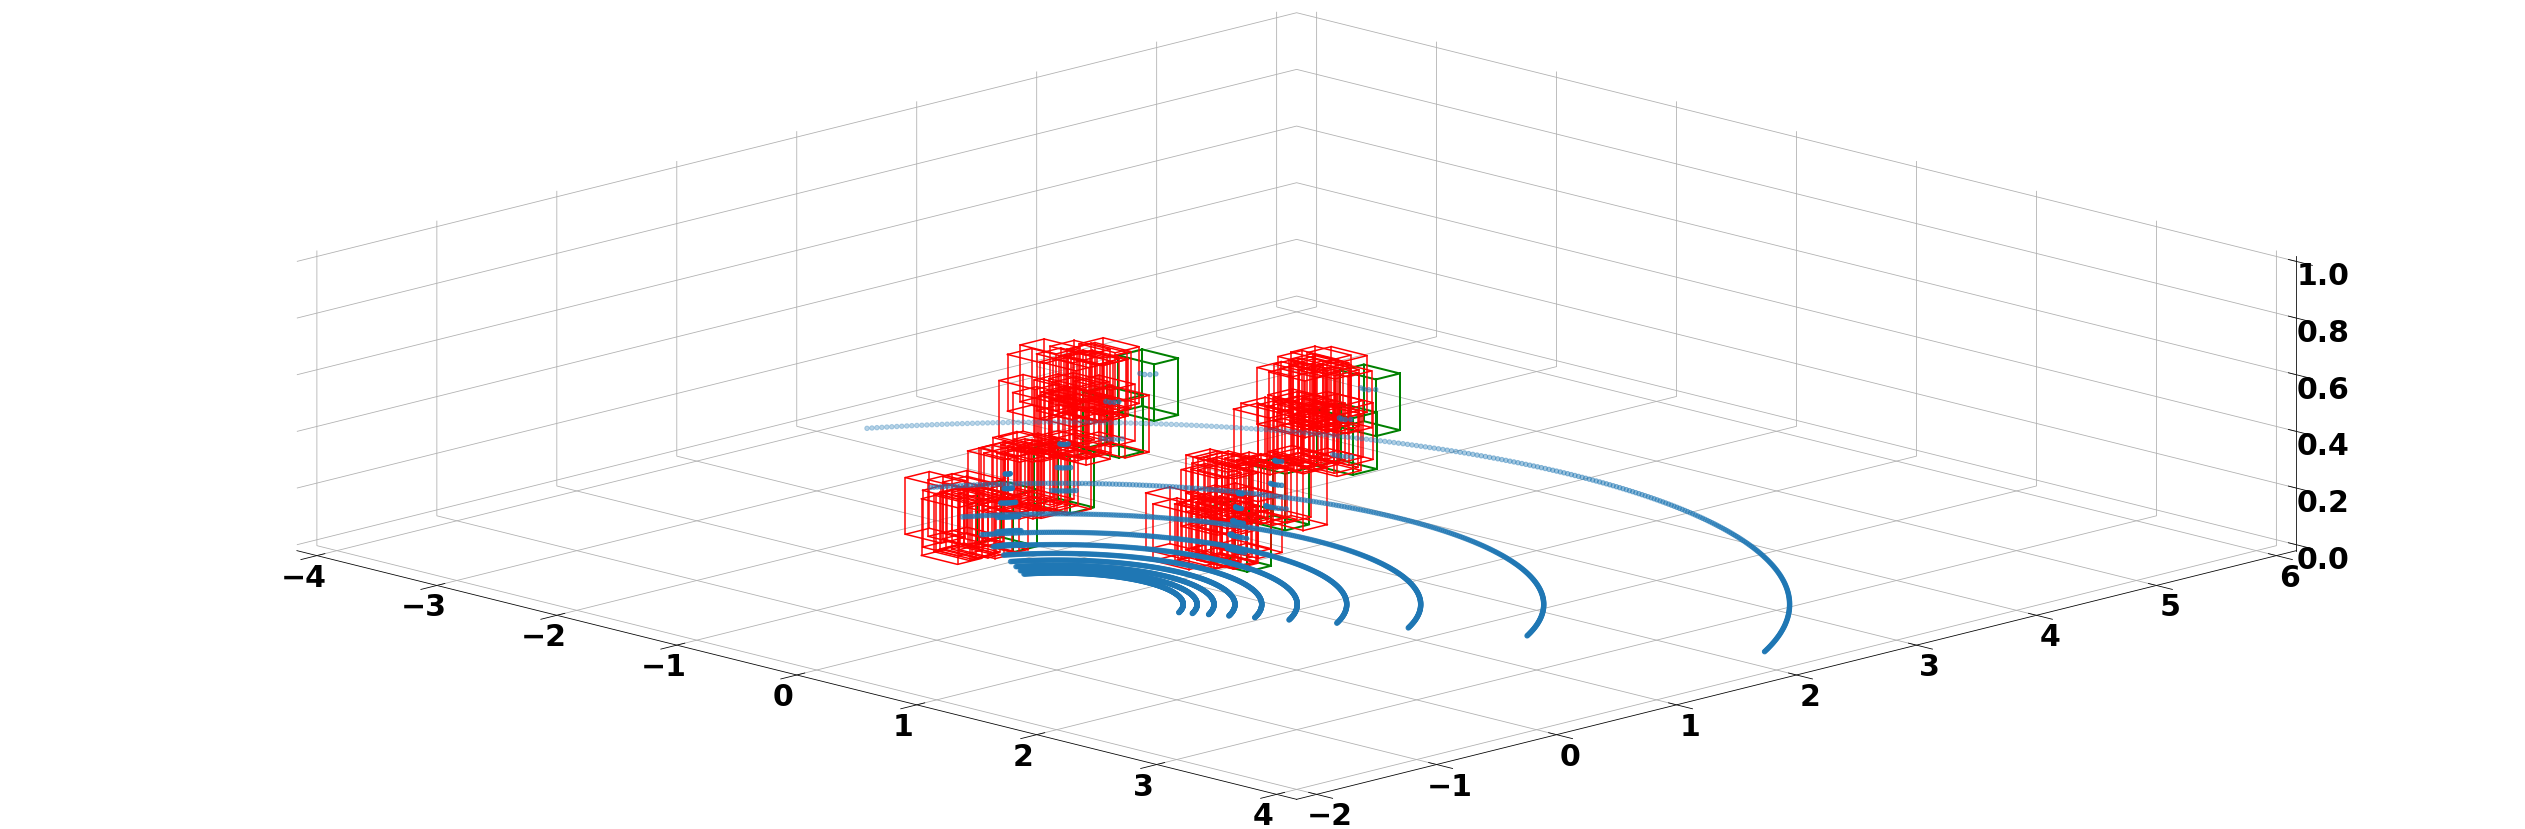

torch.Size([200])


In [ ]:
id = 1
model.eval() # shut down dropout layer
image = train_data[id-1:id+31,:,:]
image = np.expand_dims(image,1)
image = torch.from_numpy(image).float().to(device='cuda')
with torch.no_grad():
  outputs = model(image)
output = outputs[0,:]

# denormalize
outxy = output.reshape(2,100)
outxy[0,:] = outxy[0,:]/100*10-5
outxy[1,:] = outxy[1,:]/100*5
output = outxy.reshape(200)
cpu_output = output.to(device='cpu')
illustration(DATA_DIR, id, cpu_output,0)
print(output.shape)

### non maximum suppression

**Code is found online, not perfect, optimization is needed**

In [ ]:
# import the necessary packages

def non_max_suppression(boxes, overlapThresh):
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	# print(area)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("float")

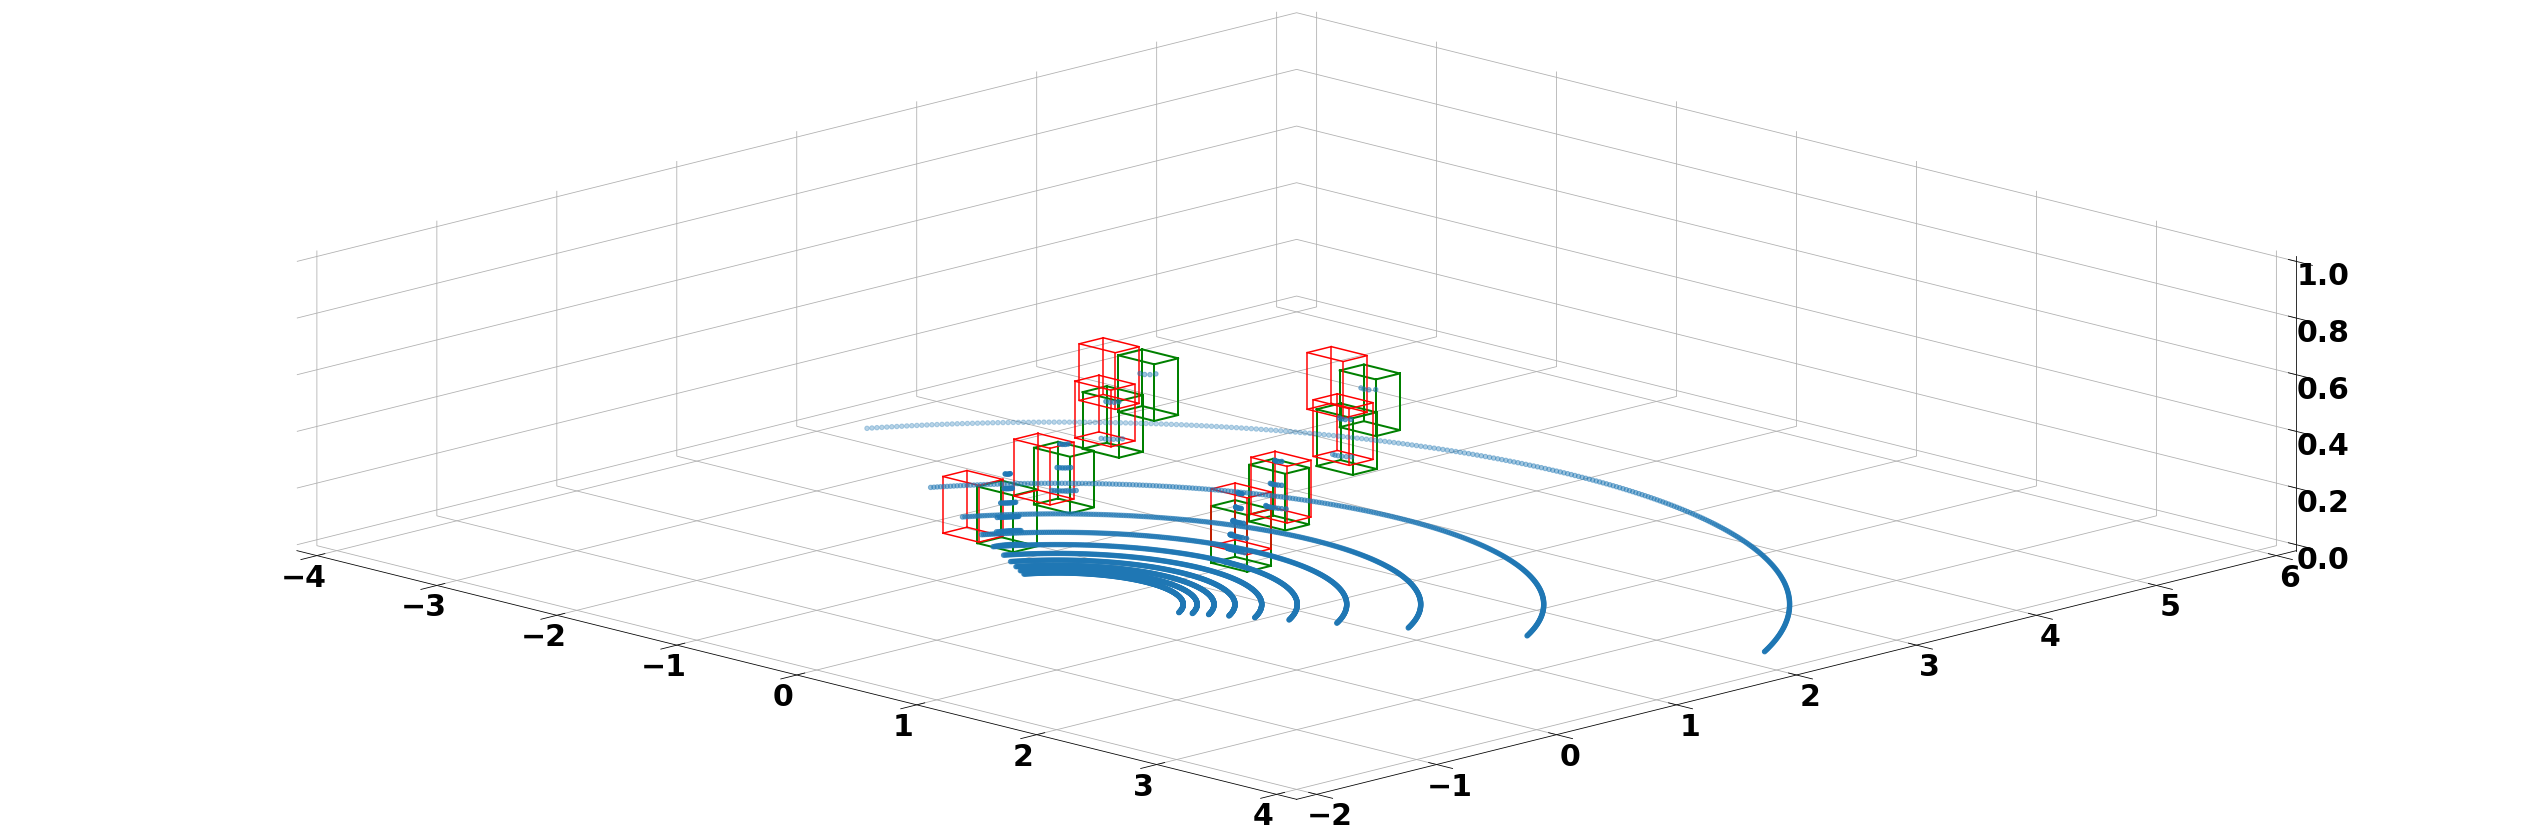

In [ ]:
id = 1
model.eval()
image = train_data[id-1:id+31,:,:]
image = np.expand_dims(image,1)
image = torch.from_numpy(image).float().to(device='cuda')
with torch.no_grad():
  outputs = model(image)
output = outputs[0,:]  # [200]
output = output.to(device='cpu')

outxy = output.reshape(2, 100)
# denormalize
outxy[0,:] = outxy[0,:]/100*10-5
outxy[1,:] = outxy[1,:]/100*5

outxy = outxy[0:2,:].T
boxes = np.hstack((outxy-0.2, outxy+0.2))
overlapThresh = 0.5
picked = non_max_suppression(boxes, overlapThresh)
picked = picked[:,0:2]+0.2
picked = picked.T

illustration(DATA_DIR, id, picked,1)
 

## Playground

In [ ]:
def data_loader(folder):
  voxels = []
  n = 100
  positions=np.empty((2048,3,n)) # not always filled

  files = sorted(glob.glob(os.path.join(folder, 'ply/*')))
  pos_files = sorted(glob.glob(os.path.join(folder, 'csv/*')))

  # for f in files:
  #   plydata = PlyData.read(f)
  #   x = np.array(plydata.elements[0].data['x'])
  #   y = np.array(plydata.elements[0].data['y'])
  #   z = np.array(plydata.elements[0].data['z'])
  #   x = np.expand_dims(x,1)
  #   y = np.expand_dims(y,1)
  #   z = np.expand_dims(z,1)
  #   xy = np.hstack((x, y))
  #   pc = np.hstack((xy, z))
  #   voxel, npc = raw_to_voxel(pc, resolution=0.1, x=(-5, 5), y=(0, 5), z=(0, 0.3))
  #   voxels.append(voxel)
  

  j=0
  for f in pos_files:
    with open(f, 'r') as file:
      reader = csv.reader(file)
      i=0
      for row in reader:
        row = np.array(row)
        num_loops = math.floor(n/len(row))
        remainder = n%len(row)
        for k in range(num_loops):
          positions[j][i][len(row)*k:len(row)*(k+1)] = row
        positions[j][i][n-remainder:] = row[0:remainder]
        i=i+1
    j=j+1
  positions[:,2,:] = 0.2

  voxels = np.array(voxels)
  total = len(files)
  train_voxels, test_voxels= [],[]
  train_positions, test_positions= positions[0:int(0.8*total)], positions[int(0.8*total)+1:]
  return train_voxels, test_voxels, train_positions, test_positions

In [ ]:
train_voxels, test_voxels, train_positions, test_positions= data_loader(DATA_DIR)

In [ ]:
a= train_positions
a1 = a[:,0,:]
a2 = a[:,1,:]
a3 = a[:,2,:]
b = torch.column_stack(a1,a2,a3)

b[0,:]

TypeError: ignored

In [ ]:
a.shape

(1638, 3, 100)

In [ ]:
DATA_DIR = '/content/myDataset'

In [ ]:
Y = torch.rand(2, 3, device='cuda')

In [ ]:
x = torch.tensor([1, 2, 3])
x.device

device(type='cpu')

In [ ]:
Y

tensor([[0.8903, 0.0275, 0.9031],
        [0.5386, 0.7312, 0.9047]], device='cuda:0')

In [ ]:
!nvidia-smi

Sat Jul 24 13:05:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------